<a href="https://colab.research.google.com/github/SchmidtPhilipp/quantforce/blob/main/Quantforce_colab_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Update
!apt-get update
# Install latex
!apt-get install -y texlive-latex-recommended texlive-fonts-recommended

# Clone quantforce
!rm -rf quantforce
!git clone https://github.com/SchmidtPhilipp/quantforce.git

# Install quantforce requriements
!pip install -r quantforce/qf/requirements/requirements.txt

# Install quantforce module
!pip install -e quantforce/.



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

import qf
import warnings
warnings.filterwarnings("ignore")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
# Create environment
train_env = qf.MultiAgentPortfolioEnv(
    "TRAIN", n_agents=1, env_config=qf.EnvConfig.get_default_train()
)

eval_env = qf.MultiAgentPortfolioEnv(
    "EVAL", n_agents=1, env_config=qf.EnvConfig.get_default_eval()
)

total_timesteps=100_000

# Define different agent configurations to compare
# Each tuple contains: (name, agent_class, config)
agents_to_compare = [
    # Classic Agents
    (
        "Tangency_Sample",
        qf.ClassicOnePeriodMarkowitzAgent,
        qf.agents.ClassicOnePeriodMarkowitzAgentConfig(
            target="Tangency",
            risk_model="sample_cov",
        ),
    ),
    (
        "Tangency_ML",
        qf.ClassicOnePeriodMarkowitzAgent,
        qf.agents.ClassicOnePeriodMarkowitzAgentConfig(
            target="Tangency",
            risk_model="ML_brownian_motion_logreturn",
        ),
    ),
    ("1/N", qf.OneOverNPortfolioAgent, qf.agents.OneOverNPortfolioAgentConfig()),
    #("Merton", qf.HJBPortfolioAgent, qf.agents.HJBPortfolioAgentConfig()),
    #("SAC", qf.SACAgent, qf.agents.SACConfig()),
    #("PPO", qf.PPOAgent, qf.agents.PPOConfig()),
    #("DDPG", qf.DDPGAgent, qf.agents.DDPGConfig()),
    #("MADDPG", qf.MADDPGAgent, qf.agents.MADDPGConfig()),
]

In [4]:
# Train and evaluate each agent
runs = []
for name, agent_class, config in agents_to_compare:
    print(f"\nTraining {name}...")


    # Create agent with specific configuration
    agent = agent_class(train_env, config=config)


    agent.train(total_timesteps=total_timesteps)

    # Hard reset the environment (important to reset the data collector)
    eval_env = qf.MultiAgentPortfolioEnv(
        "EVAL", n_agents=1, env_config=qf.EnvConfig.get_default_eval()
    )

    # Evaluate agent
    agent.evaluate(episodes=1, eval_env=eval_env)

    # Collect results
    run = eval_env.data_collector
    run.rename(name)
    runs.append(run)

    print(f"✓ {name} completed successfully")






Training Tangency_Sample...
Saving ClassicOnePeriodMarkowitzAgent to ./runs/2025-09-16-12-54-47_DEFAULT_TRAIN_CONFIG_TRAIN/best_model/ClassicOnePeriodMarkowitzAgent.pt


Evaluating ClassicOnePeriodMarkowitzAgent:   0%|          | 0/1 [00:00<?, ?it/s]

Episode 1:   0%|          | 0/1139 [00:00<?, ?it/s]

Saving ClassicOnePeriodMarkowitzAgent to ./runs/2025-09-16-12-54-52_DEFAULT_EVAL_CONFIG_EVAL/ClassicOnePeriodMarkowitzAgent.pt
✓ Tangency_Sample completed successfully

Training Tangency_ML...
Saving ClassicOnePeriodMarkowitzAgent to ./runs/2025-09-16-12-54-47_DEFAULT_TRAIN_CONFIG_TRAIN/best_model/ClassicOnePeriodMarkowitzAgent.pt


Evaluating ClassicOnePeriodMarkowitzAgent:   0%|          | 0/1 [00:00<?, ?it/s]

Episode 1:   0%|          | 0/1139 [00:00<?, ?it/s]

Saving ClassicOnePeriodMarkowitzAgent to ./runs/2025-09-16-12-55-03_DEFAULT_EVAL_CONFIG_EVAL/ClassicOnePeriodMarkowitzAgent.pt
✓ Tangency_ML completed successfully

Training 1/N...


Evaluating OneOverNPortfolioAgent:   0%|          | 0/1 [00:00<?, ?it/s]

Episode 1:   0%|          | 0/1139 [00:00<?, ?it/s]

✓ 1/N completed successfully

Training Merton...


Evaluating HJBPortfolioAgent:   0%|          | 0/1 [00:00<?, ?it/s]

Episode 1:   0%|          | 0/1139 [00:00<?, ?it/s]

✓ Merton completed successfully


In [5]:
# Visualize results
frame = [run.get_frame() for run in runs]

frames = qf.PlotFrame(pd.concat(frame, ignore_index=False, axis=1))

# Define the plotconfig
plot_config = qf.PlotConfig.jupyter()

In [6]:
qf.PlotFrame(frame).plot_confidence_balance(frame, mean_of_level="run", plot_config=plot_config)

✅ Saved to plots/balance_confidence.{png}


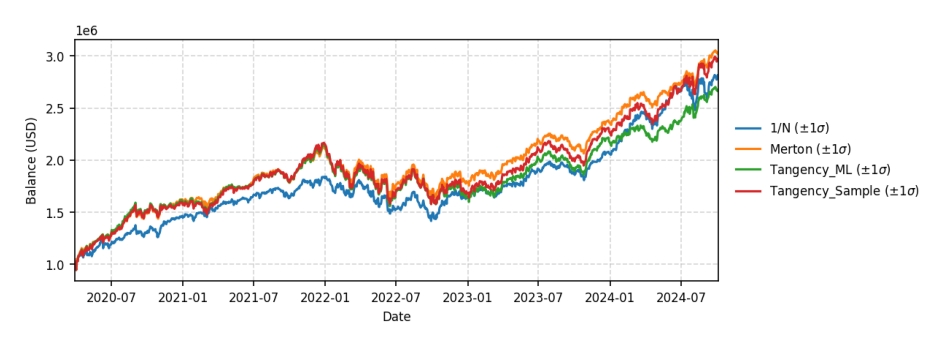

In [7]:
img = mpimg.imread('plots/balance_confidence.png')
plt.imshow(img)
plt.axis('off')
plt.show()